In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(['EIN', 'NAME'], axis=1)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [4]:
# Replace values in APPLICATION_TYPE if count is less than 500
app_type_count = application_df.APPLICATION_TYPE.value_counts()
replace_application = list(app_type_count[app_type_count < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [5]:
# Replace values in CLASSIFICATION if count is less than 1000
classification_counts = application_df.CLASSIFICATION.value_counts()
replace_class = list(classification_counts[classification_counts < 1000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

# Optimization attempt 1: find and remove outliers, train the original model

In [6]:
# Check INCOME_AMT
income_count = application_df.INCOME_AMT.value_counts()
income_count

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

<AxesSubplot:ylabel='Density'>

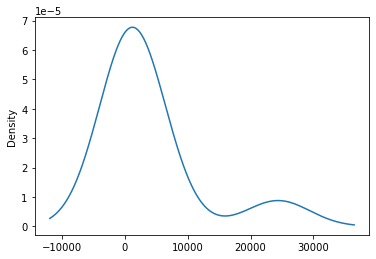

In [7]:
# Visualize INCOME_AMT
income_count.plot.density()

In [8]:
# Get stat summary of ASK_AMT
application_df.ASK_AMT.describe()

count    3.429900e+04
mean     2.769199e+06
std      8.713045e+07
min      5.000000e+03
25%      5.000000e+03
50%      5.000000e+03
75%      7.742000e+03
max      8.597806e+09
Name: ASK_AMT, dtype: float64

In [9]:
# Check median to determine skew
application_df.ASK_AMT.median()

5000.0

<AxesSubplot:>

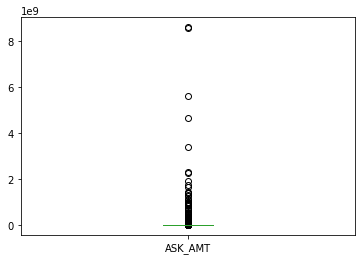

In [10]:
# Visualize outliers
application_df["ASK_AMT"].plot.box()

<AxesSubplot:ylabel='Density'>

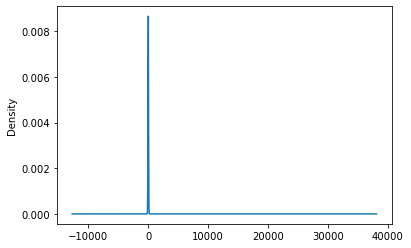

In [11]:
# Visualize density
(application_df.ASK_AMT.value_counts()).plot.density()

In [12]:
# Calculate IQR to find outliers in ASK_AMT
iqr = (np.percentile(application_df.ASK_AMT, 75)) - (np.percentile(application_df.ASK_AMT, 25))
outlier_value = (np.percentile(application_df.ASK_AMT, 75)) + iqr * 1.5
outlier_value

11855.0

In [13]:
# Check original row count in the DataFrame
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        34299 non-null  object
 1   AFFILIATION             34299 non-null  object
 2   CLASSIFICATION          34299 non-null  object
 3   USE_CASE                34299 non-null  object
 4   ORGANIZATION            34299 non-null  object
 5   STATUS                  34299 non-null  int64 
 6   INCOME_AMT              34299 non-null  object
 7   SPECIAL_CONSIDERATIONS  34299 non-null  object
 8   ASK_AMT                 34299 non-null  int64 
 9   IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.6+ MB


In [14]:
# Save outliers in dataframe
outlier_df = application_df[application_df.ASK_AMT > outlier_value]
outlier_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8206 entries, 1 to 34298
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        8206 non-null   object
 1   AFFILIATION             8206 non-null   object
 2   CLASSIFICATION          8206 non-null   object
 3   USE_CASE                8206 non-null   object
 4   ORGANIZATION            8206 non-null   object
 5   STATUS                  8206 non-null   int64 
 6   INCOME_AMT              8206 non-null   object
 7   SPECIAL_CONSIDERATIONS  8206 non-null   object
 8   ASK_AMT                 8206 non-null   int64 
 9   IS_SUCCESSFUL           8206 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 705.2+ KB


In [15]:
# Drop outliers in dataframe
trimmed_application_df = application_df.drop(application_df[application_df["ASK_AMT"] > outlier_value].index)
trimmed_application_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26093 entries, 0 to 34297
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        26093 non-null  object
 1   AFFILIATION             26093 non-null  object
 2   CLASSIFICATION          26093 non-null  object
 3   USE_CASE                26093 non-null  object
 4   ORGANIZATION            26093 non-null  object
 5   STATUS                  26093 non-null  int64 
 6   INCOME_AMT              26093 non-null  object
 7   SPECIAL_CONSIDERATIONS  26093 non-null  object
 8   ASK_AMT                 26093 non-null  int64 
 9   IS_SUCCESSFUL           26093 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.2+ MB


In [16]:
# Generate our categorical variable lists
trimmed_application_cat = trimmed_application_df.dtypes[trimmed_application_df.dtypes == "object"].index.tolist()
trimmed_application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [17]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(trimmed_application_df[trimmed_application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(trimmed_application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
# Merge one-hot encoded features and drop the originals
trimmed_application_df = trimmed_application_df.merge(encode_df, left_index=True, right_index=True)
trimmed_application_df = trimmed_application_df.drop(trimmed_application_cat, 1)
trimmed_application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1,5000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1,5000,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
# Split our preprocessed data into our features and target arrays
y = trimmed_application_df["IS_SUCCESSFUL"].values
X = trimmed_application_df.drop(["IS_SUCCESSFUL"], 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [20]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [21]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
input_features = len(X_train[0])
nodes_layer1 = 80
nodes_layer2 = 30

nn2 = tf.keras.models.Sequential()

# First hidden layer
nn2.add(tf.keras.layers.Dense(input_dim=input_features, units=nodes_layer1, activation="relu"))

# Second hidden layer
nn2.add(tf.keras.layers.Dense(units=nodes_layer2, activation="relu"))

# Output layer
nn2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                3520      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 5,981
Trainable params: 5,981
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile the model
nn2.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [23]:
# Save checkpoints

# Create checkpoint path and file
os.makedirs("checkpoints_nn2/", exist_ok=True)
checkpoint_path = "checkpoints_nn2/weights.{epoch:03d}.hdf5"

# Create a callback that saves weights every 5 checkpoints
cp_callback = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only = True, period=5)

In [24]:
# Train the model
fit_model = nn2.fit(X_train_scaled, y_train, epochs=100, callbacks = [cp_callback])

Epoch 1/100
470/470 [==============================] - 1s 485us/step - loss: 0.7039 - accuracy: 0.5107
Epoch 2/100
470/470 [==============================] - 0s 489us/step - loss: 0.6938 - accuracy: 0.5262
Epoch 3/100
470/470 [==============================] - 0s 483us/step - loss: 0.6908 - accuracy: 0.5385
Epoch 4/100
470/470 [==============================] - 0s 481us/step - loss: 0.6900 - accuracy: 0.5299
Epoch 5/100
470/470 [==============================] - 0s 483us/step - loss: 0.6900 - accuracy: 0.5366

Epoch 00005: saving model to checkpoints_nn2\weights.005.hdf5
Epoch 6/100
470/470 [==============================] - 0s 483us/step - loss: 0.6905 - accuracy: 0.5347
Epoch 7/100
470/470 [==============================] - 0s 483us/step - loss: 0.6890 - accuracy: 0.5375
Epoch 8/100
470/470 [==============================] - 0s 485us/step - loss: 0.6892 - accuracy: 0.5411
Epoch 9/100
470/470 [==============================] - 0s 478us/step - loss: 0.6859 - accuracy: 0.5426
Epoch 10/1

In [25]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

157/157 - 0s - loss: 0.7394 - accuracy: 0.5242
Loss: 0.7394065260887146, Accuracy: 0.5242466330528259


# Optimization attempt 2: 
Use original (untrimmed) data, increase the number of neurons in hidden layer 2 to 50% of neurons in hidden layer1, add 3 hidden layer with 50% neurons of hidden layer 2

In [26]:
# Check original dataframe
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        34299 non-null  object
 1   AFFILIATION             34299 non-null  object
 2   CLASSIFICATION          34299 non-null  object
 3   USE_CASE                34299 non-null  object
 4   ORGANIZATION            34299 non-null  object
 5   STATUS                  34299 non-null  int64 
 6   INCOME_AMT              34299 non-null  object
 7   SPECIAL_CONSIDERATIONS  34299 non-null  object
 8   ASK_AMT                 34299 non-null  int64 
 9   IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.6+ MB


In [27]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [28]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"], 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [31]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [32]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
input_features = len(X_train[0])
nodes_layer1 = 80
nodes_layer2 = 40
nodes_layer3 = 20

nn3 = tf.keras.models.Sequential()

# First hidden layer
nn3.add(tf.keras.layers.Dense(input_dim=input_features, units=nodes_layer1, activation="relu"))

# Second hidden layer
nn3.add(tf.keras.layers.Dense(units=nodes_layer2, activation="relu"))

# Third hidden layer
nn3.add(tf.keras.layers.Dense(units=nodes_layer3, activation="relu"))

# Output layer
nn3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 80)                3520      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 7,601
Trainable params: 7,601
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the model
nn3.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [34]:
# Save checkpoints

# Create checkpoint path and file
os.makedirs("checkpoints_nn3/", exist_ok=True)
checkpoint_path = "checkpoints_nn3/weights.{epoch:03d}.hdf5"

# Create a callback that saves weights every 5 checkpoints
cp_callback = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only = True, period=5)

In [35]:
# Train the model
fit_model = nn3.fit(X_train_scaled, y_train, epochs=100, callbacks = [cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 513us/step - loss: 0.5869 - accuracy: 0.7049
Epoch 2/100
804/804 [==============================] - 0s 517us/step - loss: 0.5507 - accuracy: 0.7299
Epoch 3/100
804/804 [==============================] - 0s 517us/step - loss: 0.5491 - accuracy: 0.7308
Epoch 4/100
804/804 [==============================] - 0s 514us/step - loss: 0.5457 - accuracy: 0.7371
Epoch 5/100
804/804 [==============================] - 0s 517us/step - loss: 0.5479 - accuracy: 0.7316

Epoch 00005: saving model to checkpoints_nn3\weights.005.hdf5
Epoch 6/100
804/804 [==============================] - 0s 516us/step - loss: 0.5455 - accuracy: 0.7378
Epoch 7/100
804/804 [==============================] - 0s 515us/step - loss: 0.5439 - accuracy: 0.7359
Epoch 8/100
804/804 [==============================] - 0s 517us/step - loss: 0.5444 - accuracy: 0.7369
Epoch 9/100
804/804 [==============================] - 0s 515us/step - loss: 0.5394 - accuracy: 0.7382
Epoch 10/1

In [36]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5716 - accuracy: 0.7261
Loss: 0.5715515613555908, Accuracy: 0.726064145565033


# Optimization 3:
Double the number of epochs on model from Optimization 2

In [40]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
input_features = len(X_train[0])
nodes_layer1 = 80
nodes_layer2 = 40
nodes_layer3 = 20

nn4 = tf.keras.models.Sequential()

# First hidden layer
nn4.add(tf.keras.layers.Dense(input_dim=input_features, units=nodes_layer1, activation="relu"))

# Second hidden layer
nn4.add(tf.keras.layers.Dense(units=nodes_layer2, activation="relu"))

# Third hidden layer
nn4.add(tf.keras.layers.Dense(units=nodes_layer3, activation="relu"))

# Output layer
nn4.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 80)                3520      
_________________________________________________________________
dense_12 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_13 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 21        
Total params: 7,601
Trainable params: 7,601
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Compile the model
nn4.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [39]:
# Save checkpoints

# Create checkpoint path and file
os.makedirs("checkpoints_nn4/", exist_ok=True)
checkpoint_path = "checkpoints_nn4/weights.{epoch:03d}.hdf5"

# Create a callback that saves weights every 5 checkpoints
cp_callback = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only = True, period=5)

In [43]:
# Train the model
fit_model = nn4.fit(X_train_scaled, y_train, epochs=200, callbacks = [cp_callback])

Epoch 1/200
804/804 [==============================] - 0s 510us/step - loss: 0.5407 - accuracy: 0.7370
Epoch 2/200
804/804 [==============================] - 0s 505us/step - loss: 0.5401 - accuracy: 0.7378
Epoch 3/200
804/804 [==============================] - 0s 509us/step - loss: 0.5399 - accuracy: 0.7384
Epoch 4/200
804/804 [==============================] - 0s 512us/step - loss: 0.5400 - accuracy: 0.7376

Epoch 00004: saving model to checkpoints_nn4\weights.004.hdf5
Epoch 5/200
804/804 [==============================] - 0s 515us/step - loss: 0.5395 - accuracy: 0.7378
Epoch 6/200
804/804 [==============================] - 0s 514us/step - loss: 0.5391 - accuracy: 0.7375
Epoch 7/200
804/804 [==============================] - 0s 503us/step - loss: 0.5393 - accuracy: 0.7376
Epoch 8/200
804/804 [==============================] - 0s 513us/step - loss: 0.5389 - accuracy: 0.7386
Epoch 9/200
804/804 [==============================] - 0s 510us/step - loss: 0.5389 - accuracy: 0.7389

Epoch 000

In [44]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn4.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6094 - accuracy: 0.7266
Loss: 0.6094494462013245, Accuracy: 0.7266472578048706
